
# Predictive Model for Indentifying Fraudulent Activities
* Business Objective
* Data Collection and Understanding
* Exploratory Data Analysis
* Data Preparation
* Predictive Modeling
* Testing and Evaluation
* Deployment

## 1. Business Objective: 
* Company XYZ is an e-commerce site that sells hand-made clothes. E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etJ.
* The goal of this challenge is to build a machine learning model that predicts the probability that the ﬁrst transaction of a new user is fraudulent.
* Tasks:
    * For each user, determine her country based on the numeric IP address.
    * Build a model to predict whether an activity is fraudulent or not. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.
    * Explain from a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics?
    * From a product perspective, how would you use it? That is, what kind of diﬀerent user experiences would you build based on the model output?

## 2. Data Collection and Understanding:

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the dataset
fraud = pd.read_csv('Fraud_Data.csv')
ip = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
# Overview for the dataset and variables
import pandas_profiling
pandas_profiling.ProfileReport(fraud)

Number of variables,11
Number of observations,151112
Total Missing (%),0.0%
Total size in memory,12.7 MiB
Average record size in memory,88.0 B
Numeric,4
Categorical,5
Boolean,1
Date,0
Text (Unique),1
Rejected,0


In [4]:
# Look at the first few rows of the datasets
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


#### Data Dictionary:
##### _"Fraud_Data"
* user_id : Id of the user. Unique by user 
* signup_time : the time when the user created her account (GMT time) 
* purchase_time : the time when the user bought the item (GMT time) 
* purchase_value : the cost of the item purchased (USD) 
* device_id : the device id. You can assume that it is unique by device. I.e., 2 transaJtions with the same device ID means that the same physical device was used to buy
* source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).
* browser : the browser used by the user.
* sex : user sex: Male/Female 
* age : user age 
* ip_address : user numeric ip address 
* class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).

##### _"IpAddress_to_Country"
* lower_bound_ip_address : the lower bound of the numeric ip address for that country 
* upper_bound_ip_address : the upper bound of the numeric ip address for that country 
* country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.

In [6]:
# Look at the information for the datasets
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
# Check duplicates
fraud.duplicated().sum()

0

#### Summary from Data Understanding:
* No missing values, and no duplicates
* No high correlation among variables
* The target variable (class) is binary: 1 for fraudulent, 0 for non fraudulent (majority)

## 3. Exploratory Data Analysis:
* Univariate visualization and summary statistics for each field in the raw dataset
* Bivariate visualization and summary statistics for assessing the relationship between each variable in the dataset and the target variable
* Multivariate visualizations to understand interactions between different fields in the data
* Feature Engineering: use domain knowledge to create additional relevant features from the existing raw features in the data, and to increase the predictive power of the learning algorithm

In [9]:
# Import python modules for visualization
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set_style('whitegrid')

### 3.1 Univariate Analysis

#### 3.1.1 Numerical variables

In [10]:
# Summary for numerical variables
fraud.describe(include=['int64', 'float64'])

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


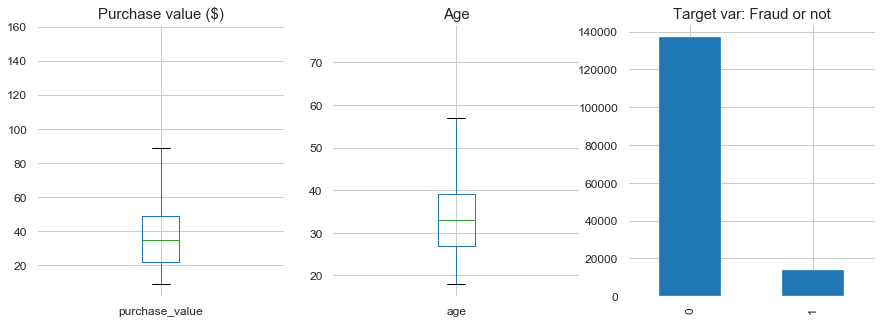

In [11]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

fraud.purchase_value.plot.box(ax=axarr[0], fontsize=12)
axarr[0].set_title("Purchase value ($)", fontsize=15)

fraud.age.plot.box(ax=axarr[1], fontsize=12)
axarr[1].set_title("Age", fontsize=15)

fraud['class'].value_counts().plot.bar(ax=axarr[2], fontsize=12)
axarr[2].set_title("Target var: Fraud or not", fontsize=15)

plt.subplots_adjust(hspace=.3)

seaborn.despine()

#### 3.1.2 Categorical variables

In [12]:
# Summary for categorical variables
fraud.describe(include=['object'])

,signup_time,purchase_time,device_id,source,browser,sex
count,151112,151112,151112,151112,151112,151112
unique,151112,150679,137956,3,5,2
top,2015-03-05 15:04:33,2015-09-10 09:04:53,KIPFSCNUGOLDP,SEO,Chrome,M
freq,1,3,20,60615,61432,88293


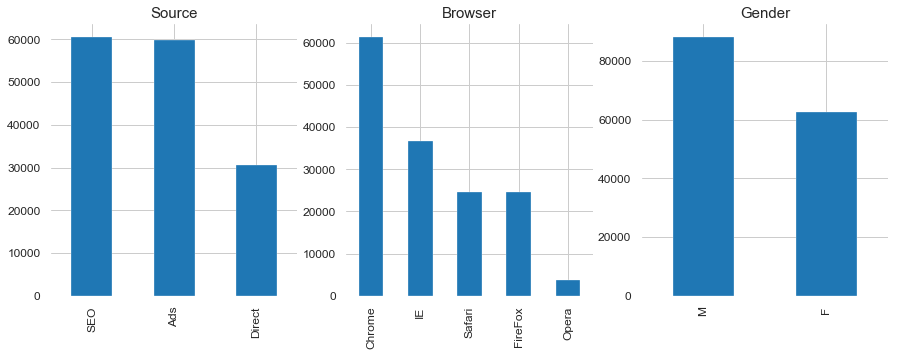

In [13]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

fraud['source'].value_counts().plot.bar(ax=axarr[0], fontsize=12)
axarr[0].set_title("Source", fontsize=15)

fraud['browser'].value_counts().plot.bar(ax=axarr[1], fontsize=12)
axarr[1].set_title("Browser", fontsize=15)

fraud['sex'].value_counts().plot.bar(ax=axarr[2], fontsize=12)
axarr[2].set_title("Gender", fontsize=15)

plt.subplots_adjust(hspace=.3)

seaborn.despine()

In [14]:
# signup time and purchase time
fraud.signup_time = pd.to_datetime(fraud.signup_time)
fraud.purchase_time = pd.to_datetime(fraud.purchase_time)

In [15]:
# Country for ip addresses
ip['country'].unique()

array(['Australia', 'China', 'Japan', 'Thailand', 'India', 'Malaysia',
       'Korea Republic of', 'Hong Kong',
       'Taiwan; Republic of China (ROC)', 'Philippines', 'Viet Nam',
       'France', 'European Union', 'United Kingdom', 'Italy',
       'United Arab Emirates', 'Israel', 'Ukraine', 'Russian Federation',
       'Sweden', 'Kazakhstan', 'Portugal', 'Greece', 'Saudi Arabia',
       'Denmark', 'Spain', 'Iran (ISLAMIC Republic Of)', 'Norway',
       'Germany', 'United States', 'Syrian Arab Republic', 'Cyprus',
       'Czech Republic', 'Switzerland', 'Iraq', 'Netherlands', 'Turkey',
       'Romania', 'Lebanon', 'Hungary', 'Georgia', 'Azerbaijan',
       'Austria', 'Palestinian Territory Occupied', 'Lithuania', 'Oman',
       'Serbia', 'Finland', 'Belgium', 'Bulgaria', 'Slovenia',
       'Moldova Republic of', 'Macedonia', 'Estonia', 'Liechtenstein',
       'Croatia (LOCAL Name: Hrvatska)', 'Poland',
       'Bosnia and Herzegowina', 'Latvia', 'Jordan', 'Kyrgyzstan',
       'Ireland

### 3.2 Feature Engineering

#### 3.2.1 Map 'ip_address' to 'country' for users

In [16]:
# Fix ip address format
fraud.ip_address = round(fraud.ip_address).astype(int)
ip['lower_bound_ip_address'] = ip['lower_bound_ip_address'].astype(int)
print(fraud.ip_address[:5])
print(ip['lower_bound_ip_address'][:5])

0     732758369
1     350311388
2    2621473820
3    3840542444
4     415583117
Name: ip_address, dtype: int64
0    16777216
1    16777472
2    16777728
3    16778240
4    16779264
Name: lower_bound_ip_address, dtype: int64


In [17]:
to_country = []
for i in range(fraud.shape[0]):
    country = ip[(fraud['ip_address'][i] >= ip['lower_bound_ip_address']) & 
                 (fraud['ip_address'][i] <= ip['upper_bound_ip_address'])
                ]['country'].values
    if len(country) == 0:
        country = 'N/A'
    else:
        country = country[0]
    to_country.append(country)

In [18]:
fraud['country'] = to_country
fraud.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0,N/A
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315200,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3987484329,0,N/A
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1692458728,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3719094257,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,341674740,0,United States


In [19]:
fraud.groupby('country').size().sort_values(ascending=False)

country
United States                           58049
N/A                                     21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                    

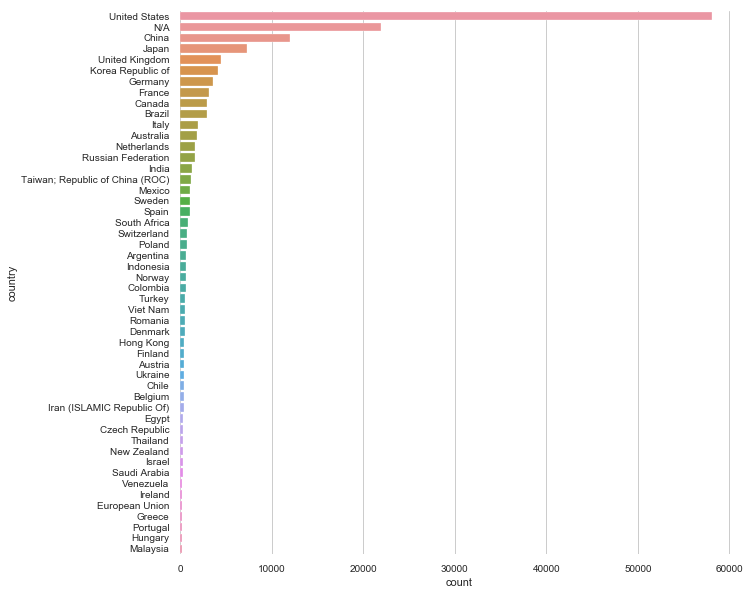

In [20]:
plt.rcParams['figure.figsize']=(10,10)
seaborn.countplot(y='country', data=fraud, order = fraud.country.value_counts().iloc[:50].index)
plt.show()

From the analysis on location, most users are located at the United States, then China, Japan, UK, etc.

#### 3.2.2 Time difference between signup_time and purchase_time

In [21]:
import datetime

fraud['signup_purchase_tdiff'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds()
fraud['signup_purchase_tdiff'].describe()

count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644525e+06
max      1.036797e+07
Name: signup_purchase_tdiff, dtype: float64

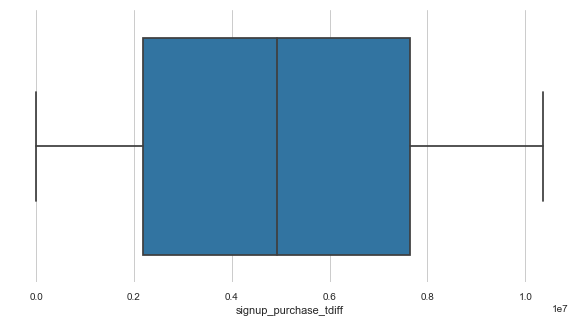

In [22]:
plt.rcParams['figure.figsize']=(10,5)
seaborn.boxplot(fraud['signup_purchase_tdiff'])

#### 3.2.3 Unique id count for each device

In [23]:
fraud.user_id.nunique(), fraud.device_id.nunique()

(151112, 137956)

In [24]:
fraud['device_user_count'] = fraud.groupby('device_id')['device_id'].transform('count')
fraud['device_user_count'].describe()

count    151112.000000
mean          1.684367
std           2.616954
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: device_user_count, dtype: float64

Multiple users from the same device might be fishy.

#### 3.2.4 Unique id count for each ip address

In [25]:
fraud.user_id.nunique(), fraud.ip_address.nunique()

(151112, 143511)

In [26]:
fraud['ip_user_count'] = fraud.groupby('ip_address')['ip_address'].transform('count')
fraud['ip_user_count'].describe()

count    151112.000000
mean          1.602732
std           2.596239
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: ip_user_count, dtype: float64

Multiple users from the same ip address might be fishy.

### 3.3 Bivariate and Multivariate Analysis

In [27]:
col_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
data = fraud.drop(columns=col_drop, axis=1)
data.head()

,purchase_value,source,browser,sex,age,class,country,signup_purchase_tdiff,device_user_count,ip_user_count
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,1,1
1,16,Ads,Chrome,F,53,0,United States,17944.0,1,1
2,15,SEO,Opera,M,53,1,United States,1.0,12,12
3,44,SEO,Safari,M,41,0,N/A,492085.0,1,1
4,39,Ads,Safari,M,45,0,United States,4361461.0,1,1


#### 3.3.1 Bivariate Analysis

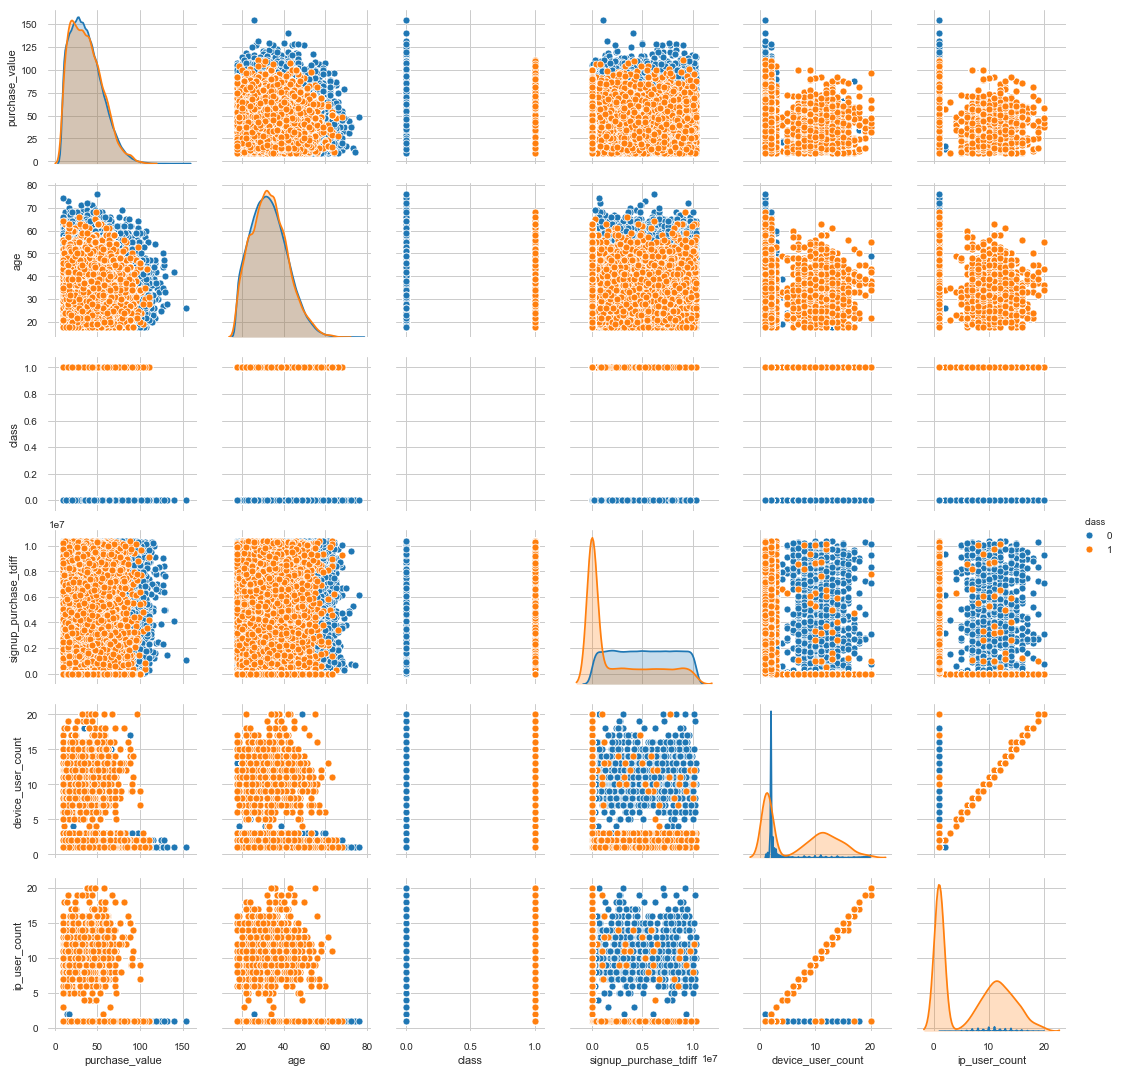

In [28]:
# Pairplot
seaborn.pairplot(data, hue='class')

In [29]:
# Correlation matrix
data.corr()

,purchase_value,age,class,signup_purchase_tdiff,device_user_count,ip_user_count
purchase_value,1.000000,0.002370,0.001011,0.003441,0.003829,0.003260
age,0.002370,1.000000,0.006624,-0.000575,0.012160,0.012168
class,0.001011,0.006624,1.000000,-0.257888,0.670837,0.658623
signup_purchase_tdiff,0.003441,-0.000575,-0.257888,1.000000,-0.331897,-0.335050
device_user_count,0.003829,0.012160,0.670837,-0.331897,1.000000,0.991082
ip_user_count,0.003260,0.012168,0.658623,-0.335050,0.991082,1.000000


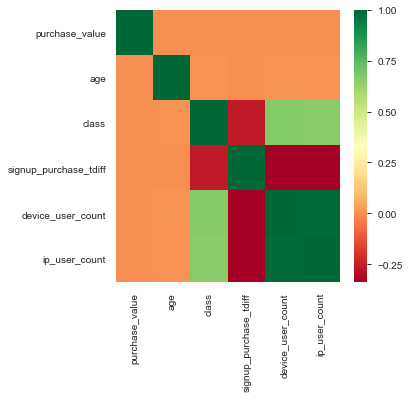

In [30]:
# Heatmap for correlation
plt.rcParams['figure.figsize']=(5,5)
seaborn.heatmap(data.corr(),cmap='RdYlGn')

#### 3.3.2 Bivariate relationship with the target variable

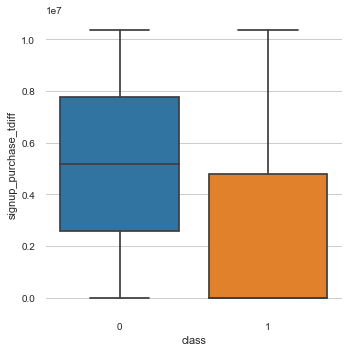

In [31]:
# signup_purchase_timedifference vs fraudulent class
seaborn.catplot(y='signup_purchase_tdiff', x='class', kind='box', data=data)

Fraudulent users usually have smaller time difference between signup time and purchase time.

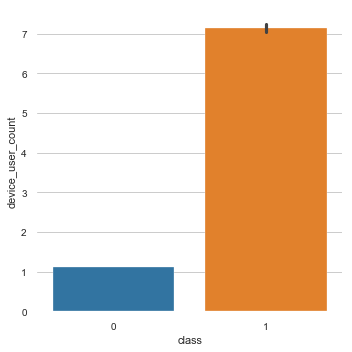

In [32]:
# number of users per device vs fraudulent class
seaborn.catplot(y='device_user_count', x='class', kind='bar', data=data)

Fraudulent activities usually occur when many user accounts shared by the same device.

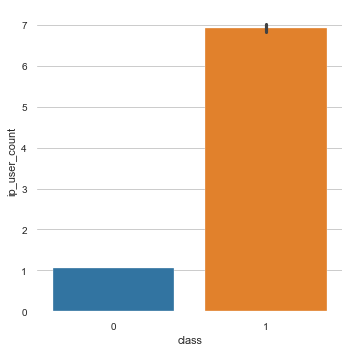

In [33]:
# number of users per ip address vs fraudulent class
seaborn.catplot(y='ip_user_count', x='class', kind='bar', data=data)

Fraudulent activities usually occur when many user accounts shared by the same ip address.

#### 3.3.3 Multivariate relationship among variables

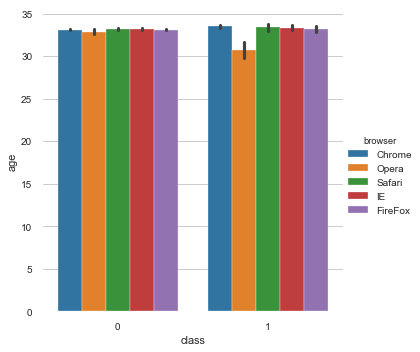

In [34]:
seaborn.catplot(y='age', x='class', hue='browser', kind='bar', data=data)

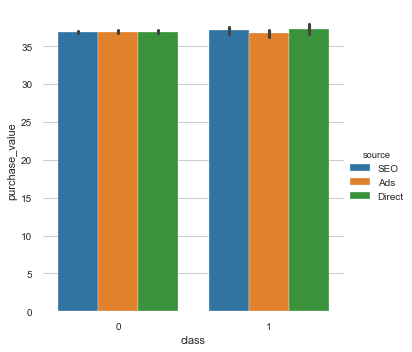

In [35]:
seaborn.catplot(y='purchase_value', x='class', hue='source', kind='bar', data=data)

From the above, we can see the fraudulent class is not significantly affected by source, browser, age, or purchase value.

## 4. Data Preparation:
* Data Cleaning: 
    * Check missing, duplicated, incorrect values (None here)
    * Getting dummies for categorical variables
* (Optional) Feature Selection / Dimensionality Reduction: to understand the fields in the data that account for the most variance between observations and allow for the processing of a reduced volume of data

### 4.1 Data Cleaning

In [36]:
# Get dummies for the categorical variables
data2 = pd.get_dummies(data, drop_first = True)
data2.head()

,purchase_value,age,class,signup_purchase_tdiff,device_user_count,ip_user_count,source_Direct,source_SEO,browser_FireFox,browser_IE,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,0,4506682.0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,0,17944.0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,15,53,1,1.0,12,12,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,44,41,0,492085.0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39,45,0,4361461.0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### 4.2 Feature Importance

In [37]:
# Define training data and target variable - retention
train_data = data2.drop(columns = 'class', axis=1)
target = data2['class']
train_data.shape, target.shape

((151112, 193), (151112,))

In [38]:
# Use random forest classifier for feature selection
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=25, n_estimators=100, n_jobs=-1)
clf.fit(train_data, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

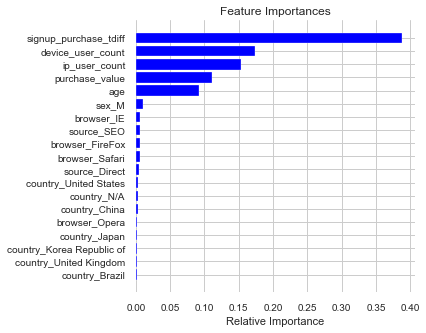

In [39]:
# Look at the top most important features
features = train_data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[-19:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 5. Predictive Modeling

### 5.1 Split training and testing sets

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120889, 193), (30223, 193), (120889,), (30223,))

### 5.2 Train model and Algorithm selection

For this prediction, I will choose to use an ensemble tree-based model, with the following reasons:
* Tree based models can handle non-numeric data, mixed data, categorical data, and can naturally handle missing data and irrelevant inputs. They empower predictive models with high accuracy, stability, lower computational complexity, and ease of interpretation. Moreover, nonlinear relationships between parameters and dimentionality do not affect tree performance.
* Ensemble methods combine several decision trees to produce better predictive performance than utilizing a single decision tree, where a group of weak learners come together to form a strong learner. By combining individual models, the ensemble model tends to be more flexible or less bias, and less data-sensitive or less variance.
* Two most popular ensemble tree-based methods are bagging and boosting:
    * Bagging: Train a bunch of individual models in a parallel way. Each model is trained by a random subset of the data.  
        * The random forest handles higher dimensionality data and missing values very well.
        * It is really good at reducing variance, at the cost of more computation and a small amount of bias.
    * Boosting: Train a bunch of individual models in a sequential way. Each individual model learns from mistakes made by the previous model.
        * Gradient Boosting learns from the mistake - residual error directly, rather than update the weights of data points. It has broader application.
        * Extreme Gradient Boosting (XGBoost) is faster and provides more regularization options, also introduces more randomization.
        * They mainly focused at reducing bias.

In [41]:
# Import the Classification modules: from both bagging and boosting ensemble methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Name the models to be used:
algorithms = [RandomForestClassifier(n_estimators=100), GradientBoostingClassifier(n_estimators=100), 
              XGBClassifier(n_estimators=100)]
names = ['RFC', 'GBC', 'XGB']

RFC Mean: 0.8395259477266416 ; Std Dev: 0.005439175134557695
GBC Mean: 0.8452777160588486 ; Std Dev: 0.006982167681983034
XGB Mean: 0.8457086258145015 ; Std Dev: 0.005434396185098323


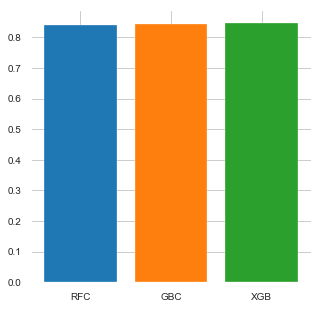

In [42]:
# Use Stratified K-fold cross validation:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

for model, name in zip(algorithms, names):
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold)
    print(name, "Mean:", cv_results.mean(), "; Std Dev:", cv_results.std())
    plt.bar(name, cv_results.mean())

From the above, XGB performs better among the 3 ensemble tree-based models.

### 5.4 Model/Parameter Tuning

In [43]:
XGBClassifier().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

#### 5.4.1 Grid Search Cross Validation

In [44]:
from sklearn.model_selection import GridSearchCV

# Step size shrinkage used in update to prevents overfitting
learning_curve = [0.05, 0.1]
# Maximum depth of a tree
max_depth = [3, 5]
# Minimum loss reduction required to make a further partition on a leaf node of the tree
gamma = [0.0, 0.1]
# Subsample ratio of the training instances
subsample = [0.6, 0.8]
# Subsample ratio of columns when constructing each tree
colsample_bytree = [0.8]
# Minimum sum of instance weight (hessian) needed in a child
min_child_weight = [1, 3]
# The number of trees (or rounds) in an XGBoost model
n_estimators = [100, 500]

# Create the  grid
param_grid = {'learning_curve': learning_curve,
              'max_depth': max_depth,
              'gamma': gamma,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'n_estimators': n_estimators}

# Create a based model
xgb = XGBClassifier(n_estimators = 100, random_state = 25)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='roc_auc', 
                           cv = 2, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 232.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_curve': [0.05, 0.1], 'max_depth': [3, 5], 'gamma': [0.0, 0.1], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.8], 'min_child_weight': [1, 3], 'n_estimators': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [45]:
# View the best parameters from fitting the grid search
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.0,
 'learning_curve': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.6}

## 6. Testing and Evaluation

### 6.1 Test the selected algorithm

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
# Base model
base_model = XGBClassifier(n_estimators = 100, random_state = 25)
base_model.fit(X_train, y_train)
# Apply the algorithm on the test data
y_pred_base = base_model.predict(X_test)
y_pred_base

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
# Model from grid search
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
# Apply the algorithm on the test data
y_pred_grid = best_grid.predict(X_test)
y_pred_grid

array([0, 0, 0, ..., 0, 0, 0])

### 6.2 View metrics for model performance

#### 6.2.1 Scores and Confusion matrix

In [49]:
# Base model
print('Base model')
print('Accuracy score: ', accuracy_score(y_test, y_pred_base))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred_base)) 
print('Classification report: ')
print(classification_report(y_test, y_pred_base))

Base model
Accuracy score:  0.9567547893988022
Confusion Matrix: 
[[27397     0]
 [ 1307  1519]]
Classification report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27397
           1       1.00      0.54      0.70      2826

   micro avg       0.96      0.96      0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



In [50]:
# Grid search model
print('Tuned model')
print('Accuracy score: ', accuracy_score(y_test, y_pred_grid))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred_grid)) 
print('Classification report: ')
print(classification_report(y_test, y_pred_grid))

Tuned model
Accuracy score:  0.9567547893988022
Confusion Matrix: 
[[27397     0]
 [ 1307  1519]]
Classification report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27397
           1       1.00      0.54      0.70      2826

   micro avg       0.96      0.96      0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



#### 6.2.2 ROC_AUC Curve

In [51]:
y_pred_prob1 = base_model.predict_proba(X_test)
y_pred_prob2 = best_grid.predict_proba(X_test)
probs1 = y_pred_prob1[:,1]
probs2 = y_pred_prob2[:,1]

In [52]:
from sklearn.metrics import roc_auc_score

print('ROC_AUC Score for')
print('Base model: ', roc_auc_score(y_test, probs1))
print('model from GridSearch: ', roc_auc_score(y_test, probs2))

ROC_AUC Score for
Base model:  0.8413617370093962
model from GridSearch:  0.8402943278951949


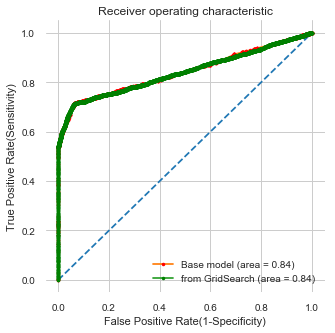

In [53]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr1, tpr1, marker='.', markerfacecolor='r',label='Base model (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, marker='.', markerfacecolor='g',label='from GridSearch (area = %0.2f)' % roc_auc2)

plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The base model is slightly better.

In [54]:
error_cutoff = pd.DataFrame({'cutoff':pd.Series(thresholds1),
                             'class0_error':pd.Series(fpr1),
                             'class1_error': 1 - pd.Series(tpr1)})
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head())

       cutoff  class0_error  class1_error  optimal_value
354  0.177680      0.061941      0.287332       0.650727
355  0.177474      0.061978      0.287332       0.650690
356  0.176467      0.062051      0.287332       0.650617
360  0.102842      0.062781      0.286624       0.650595
361  0.101910      0.062817      0.286624       0.650559


From the above analysis, the best value is in the area near (0.06, 0.71)
* false positive rate 0.06, very low
* true positive rate (1-0.287)

We want to have very low false positives and false negatives, because the cost of false positives (predicted a normal transaction as fraud) and false negatives (predicted a fraudulent transaction as normal) are both high, especially the false negatives.

## 7. Deployment

### 7.1 Prediction on probability of fraudulent detection for the given users

In [55]:
results = pd.DataFrame({
    'Actual fraud': y_test,
    'Predicted fraud': y_pred_grid,
    'prediction_probability_0': y_pred_prob2[:,0],
    'prediction_probability_1': y_pred_prob2[:,1],
    }, columns=['Actual fraud', 'Predicted fraud', 'prediction_probability_0', 'prediction_probability_1'])

results.head(20)

,Actual fraud,Predicted fraud,prediction_probability_0,prediction_probability_1
88311,0,0,0.971689,0.028311
53587,0,0,0.969232,0.030768
12007,0,0,0.971967,0.028033
28736,0,0,0.970480,0.029520
21060,0,0,0.969398,0.030602
27289,0,0,0.970616,0.029384
20313,0,0,0.801838,0.198162
50368,0,0,0.969226,0.030774
50624,0,0,0.962764,0.037236
115871,0,0,0.970825,0.029175


### 7.2 Characteristics of risky users
* Observation based on the built model
* Prediction for the first transaction of a new user

#### 7.2.1 Feature importance based on the model

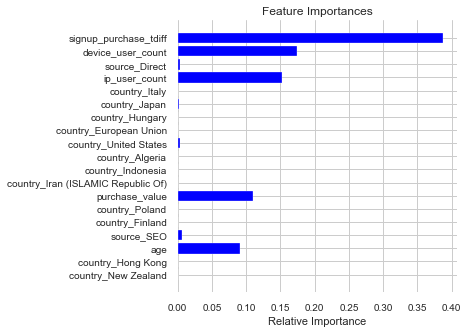

In [56]:
# Look at the important features from the predictive model
features = train_data.columns
importances_model = base_model.feature_importances_
indices_model = np.argsort(importances_model)[-19:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices_model)), importances[indices_model], color='b', align='center')
plt.yticks(range(len(indices_model)), [features[i] for i in indices_model])
plt.xlabel('Relative Importance')
plt.show()

#### 7.2.2 View Partial Dependent Plot
* Partial dependence plots show how each variable or predictor affects the model's predictions.
* Will look at the 5 features according to the feature importance ranking: signup_purchase_tdiff, device_user_count, ip_user_count, purchase_value, age.

In [57]:
from pdpbox import pdp, info_plots

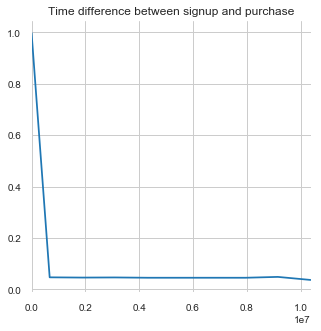

In [58]:
# signup_purchase_tdiff
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train,      
                          model_features=list(X_train), 
                          feature='signup_purchase_tdiff')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Time difference between signup and purchase')
plt.show()

We can see if a transaction has a very short time difference between signup and purchase, it is very very likely to be fraudulent.

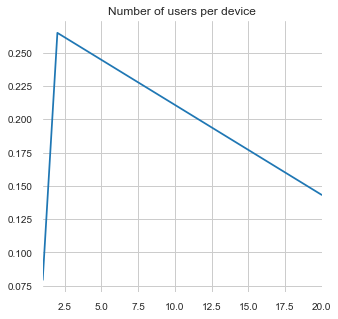

In [59]:
# device_user_count
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train,      
                          model_features=list(X_train), 
                          feature='device_user_count')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Number of users per device')
plt.show()

We can see if more than 1 users are registered on the same device, it is more likely to be fraudulent than just 1 user per device. This fraudulent probability is the highest at 2 users per device (more than 25%), but decrease as the number increases.

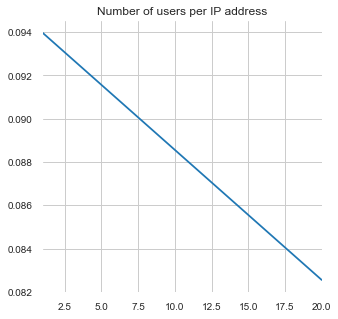

In [60]:
# ip_user_count
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train,      
                          model_features=list(X_train), 
                          feature='ip_user_count')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Number of users per IP address')
plt.show()

We can see if more than 1 users are registered at the same ip address, it is more likely to be fraudulent than just 1 per ip address. This fraudulent probability is the highest at 2 users per ip address (close to 10%), but decrease as the number increases.

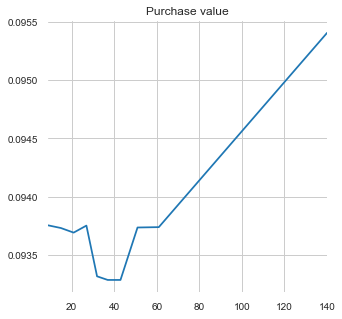

In [61]:
# purchase_value
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train,      
                          model_features=list(X_train), 
                          feature='purchase_value')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Purchase value')
plt.show()

We can see the fraudulent probability increases as the purchase value increases, lowest around $40.

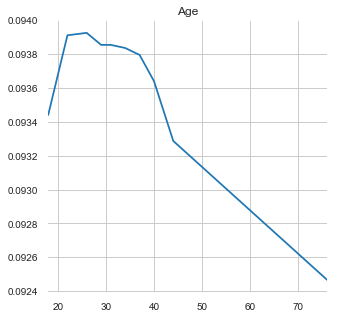

In [62]:
# age
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train,      
                          model_features=list(X_train), 
                          feature='age')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

We can see the fraudulent probability decreases as age of user increases, highest around age between 20-30.

Based on the above observations, from a user perspective, a user with the following characteristics is more likely to be classified as at risk:
* a very small time difference between signup and purchase
* multiple users from the same device
* multiple users from the same ip address
* very large purchase value

### 7.3 Insights from the model

From a product perspective, we should apply the findings from the model output to reduce risk of fraudulent occurrence and improve predictive model performance.
* Based on the model output, set alert limit and action limit on factors that impact the fraudulent detection
    * If the factor value reaches the alert limit, then collect additional user information for further verfication
    * If the factor value reaches the action limit, then hold off and review the user information manually with more evidence, to confirm if the user is actually normal or needs to be blocked.
    * Example: for predictive probability of commiting fraud, alert limit as 0.5 and action limit as 0.8
* Refine the model for better prediction power
    * Include more valuable features for fraudulent prediction
* Add more verfication upon signup (e.g. text or social media verfication)